In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
options(repr.matrix.max.rows = 6)
library(GGally)
library(ISLR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", destfile = "cleveland_data")

In [20]:
heart_disease_data <- read_delim("cleveland_data", col_names = FALSE, skip=20, delim= ",")
heart_disease_data

Rows: 283 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
64,1,1,110,211,0,2,144,1,1.8,2,0.0,3.0,0
58,0,1,150,283,1,2,162,0,1.0,1,0.0,3.0,0
58,1,2,120,284,0,2,160,0,1.8,2,0.0,3.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [21]:
names(heart_disease_data) <- c("age", "sex", "chest_pain", "resting_bp", "cholesterol", "fasting_blood_sugar", "resting_electro", "max_hr", "ex_angina", "oldpeak", "slope", "ca", "thal", "num")
heart_disease_data <- heart_disease_data |>
#mutate(sex = case_when(sex == 1 ~ "male" , sex == 0 ~ "female"))|>
#mutate(chest_pain = case_when(chest_pain == 1 ~ "typical angina", chest_pain == 2 ~ "atypical angina", chest_pain == 3 ~ "non-anginal pain", chest_pain == 4 ~ "asymptomatic"))|>
mutate(fasting_blood_sugar = case_when(fasting_blood_sugar == 1 ~ "true" , fasting_blood_sugar == 0 ~ "false"))|>
#mutate(resting_electro = case_when(resting_electro == 0 ~ "normal", resting_electro == 1 ~ "abnormal", resting_electro == 2 ~ "hypertrophy"))|>
#mutate(ex_angina = case_when(ex_angina == 1 ~ "yes" , ex_angina == 0 ~ "no"))|>
#mutate(slope = case_when(slope == 1 ~ "upsloping", slope == 2 ~ "flat", slope == 3 ~ "downsloping"))|>
#mutate(thal = case_when(thal == "3.0" ~ "normal", thal == "6.0" ~ "fixed defect", thal == "7.0" ~ "reversable defect"))|>
mutate(num = case_when(num == 0 ~ "healthy" , num == 1 ~ "sick", num == 2 ~ "sick", num == 3 ~ "sick", num == 4 ~ "sick"))|>
mutate(num = as_factor(num))
heart_disease_data$ca[heart_disease_data$ca == "?"] <- NA
heart_disease_data$thal[heart_disease_data$thal == "?"] <- NA
heart_disease_data

age,sex,chest_pain,resting_bp,cholesterol,fasting_blood_sugar,resting_electro,max_hr,ex_angina,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
64,1,1,110,211,false,2,144,1,1.8,2,0.0,3.0,healthy
58,0,1,150,283,true,2,162,0,1.0,1,0.0,3.0,healthy
58,1,2,120,284,false,2,160,0,1.8,2,0.0,3.0,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,false,0,115,1,1.2,2,1.0,7.0,sick
57,0,2,130,236,false,2,174,0,0.0,2,1.0,3.0,sick
38,1,3,138,175,false,0,173,0,0.0,1,NA,3.0,healthy


In [22]:
heart_clean <- heart_disease_data |>
select("age", "sex", "max_hr", "oldpeak", "thal", "chest_pain", "ex_angina", "num")|>
mutate(thal = as.numeric(thal))
heart_clean

age,sex,max_hr,oldpeak,thal,chest_pain,ex_angina,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
64,1,144,1.8,3,1,1,healthy
58,0,162,1.0,3,1,0,healthy
58,1,160,1.8,3,2,0,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,115,1.2,7,4,1,sick
57,0,174,0.0,3,2,0,sick
38,1,173,0.0,3,3,0,healthy


In [23]:
scaled_recipe <- recipe(num ~ ., data = heart_clean)|>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_data_scaled <- scaled_recipe |>  
    prep() |> 
    bake(heart_clean)
heart_data_scaled

age,sex,max_hr,oldpeak,thal,chest_pain,ex_angina,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.0486401,0.6928011,-0.2203456,0.67577755,-0.8943785,-2.260153,1.4154623,healthy
0.3901376,-1.4383153,0.5591270,-0.01153618,-0.8943785,-2.260153,-0.7039865,healthy
0.3901376,0.6928011,0.4725189,0.67577755,-0.8943785,-1.218421,-0.7039865,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.2803871,0.6928011,-1.476163,0.1602922,1.1614117,0.8650424,1.4154623,sick
0.2803871,-1.4383153,1.078775,-0.8706784,-0.8943785,-1.2184214,-0.7039865,sick
-1.8048710,0.6928011,1.035471,-0.8706784,-0.8943785,-0.1766895,-0.7039865,healthy


In [24]:
heart_disease_split <- initial_split(heart_data_scaled, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

In [25]:
heart_disease_table <- heart_disease_train |>
group_by(num, sex)|>
summarize(oldpeak = mean(oldpeak),
    max_hr = mean(max_hr),
    thal = mean(thal, na.rm = TRUE),
    chest_pain = mean(chest_pain, na.rm = TRUE),
    #resting_electro = mean(resting_electro, na.rm = TRUE), 
    ex_angina = mean(ex_angina, na.rm = TRUE))
heart_disease_table

`summarise()` has grouped output by 'num'. You can override using the `.groups`
argument.


num,sex,oldpeak,max_hr,thal,chest_pain,ex_angina
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
healthy,-1.4383153,-0.3940976,0.1644884,-0.8153096,-0.2749661,-0.4240593
healthy,0.6928011,-0.3766716,0.5042752,-0.2176809,-0.5065713,-0.3507451
sick,-1.4383153,0.6959927,-0.3604469,0.2846777,0.6812073,0.5427481
sick,0.6928011,0.3363116,-0.4109890,0.7172595,0.3695845,0.5108195


x Fold3: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 41 or 1, not 43.

x Fold3: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 41 or 1, not 43.



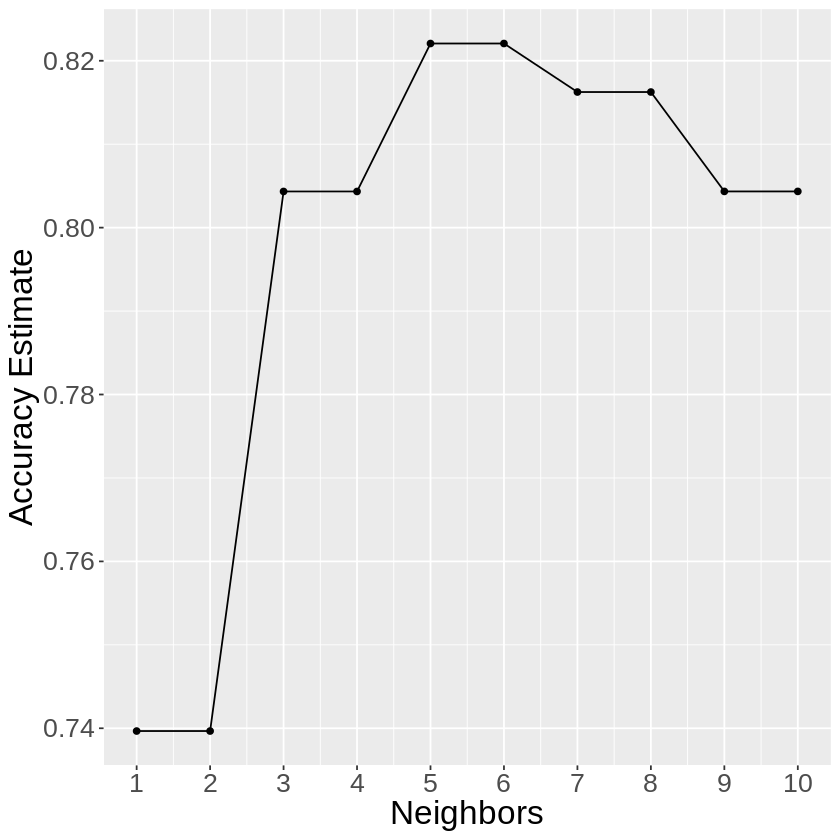

In [26]:
set.seed(2019) 

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

training_recipe <- recipe(num ~ ., data = heart_disease_train)

training_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
    set_engine("kknn") |>
    set_mode("classification")

training_resample_fit <- workflow() |>
    add_recipe(training_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = training_vfold)

grid_frame <- tibble(neighbors = (c(1,2,3,4,5,6,7,8,9,10)))

knn_results <- workflow() |>
    add_recipe(training_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = training_vfold, grid = grid_frame) |>
    collect_metrics()

accuracies <- knn_results |> 
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 10, by = 1))+
    theme(text = element_text(size = 20))
cross_val_plot

In [27]:
set.seed(2019) 

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(training_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_disease_train)
heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2047619
Best kernel: rectangular
Best k: 5

In [28]:
set.seed(2019) 

heart_predictions <- predict(heart_fit , heart_disease_test) |>
    bind_cols(heart_disease_test)
heart_predictions

heart_metrics <- heart_predictions |>
    metrics(truth = num, estimate = .pred_class)             
heart_metrics

heart_conf_mat <- heart_predictions |> 
    conf_mat(truth = num, estimate = .pred_class)
heart_conf_mat

.pred_class,age,sex,max_hr,oldpeak,thal,chest_pain,ex_angina,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
healthy,0.3901376,0.6928011,0.4725189,0.6757775,-0.8943785,-1.2184214,-0.7039865,sick
healthy,-1.1463684,0.6928011,1.2952956,-0.5270215,-0.8943785,-0.1766895,1.4154623,healthy
healthy,-1.5853701,0.6928011,1.2519916,0.3321207,1.1614117,-2.2601533,1.4154623,healthy
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
healthy,-0.8171171,0.6928011,1.2952956,-0.8706784,-0.8943785,-0.1766895,-0.7039865,healthy
sick,0.3901376,0.6928011,-0.3935618,2.9095472,0.6474642,0.8650424,-0.7039865,sick
sick,0.2803871,-1.4383153,-1.1297304,-0.6988499,1.1614117,0.8650424,1.4154623,sick


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8169014
kap,binary,0.6297633


          Truth
Prediction healthy sick
   healthy      33    8
   sick          5   25